In [65]:
historicListBK = historicList

In [154]:
# coding: utf-8

__author__ = "Sérgio José de Sousa"

import numpy as np
from heapq import heappush, heappop
from math import sqrt
import sys
import time
from PIL import Image

sys.setrecursionlimit(5000)

# Save a file with de maze and de path
printMaze = True
# Print the time of execution
printTime = True
# Print Output
printOutput = False

# Calculate the heuristic between two coordinates
# hType = heuristic name (valids = manhattan, octile, euclidean)
# vStart = start coordenate
# vGoal = goal coordenate
# return value of heuristic
def Heuristic(hType, vStart, vGoal):
    if hType == 'manhattan':
        dx = abs(vStart[0] - vGoal[0])
        dy = abs(vStart[1] - vGoal[1])
        return (dx + dy)
        
    elif hType == 'octile':
        dx = abs(vStart[0] - vGoal[0])
        dy = abs(vStart[1] - vGoal[1])
        return max(dx, dy) + 0.5 * min(dx, dy)
    elif hType == 'euclidean':
        dx = abs(vStart[0] - vGoal[0])**2
        dy = abs(vStart[1] - vGoal[1])**2
        return sqrt(dx + dy)
    
# Convert maze matrix, '@' to wall and '.' to free way, into adjacency list
# maze = matrix n x m
# width = width of the matrix
# height = height of the matrix
# withDiagonal = boolean to assign diagonal paths
# cN, cS, cE, cW, cNE, cNW, cSE, cSW = cost of the arrows
# return graph of adjacency list
def maze2graph(maze, width, height, withDiagonal, cN = 1., cS = 1., cE = 1., cW = 1., cNE = 1.5, cNW = 1.5, cSE = 1.5, cSW = 1.5):
    
    #Generate a empty dictionary with the valides vertices
    graph = {}
    for j in range(width):
        for i in range(height):
             if maze[i][j] == '.':
                    graph[(i, j)] = []
        
    #Add adjacency listo to each vertice
    for row, col in graph.keys():

        if (row < height - 1 and maze[row + 1][col] == '.'):
            graph[(row, col)].append(((row + 1, col), cS))
            graph[(row + 1, col)].append(((row, col), cN))
                     
        if (col < width - 1 and maze[row][col + 1] == '.'):            
            graph[(row, col)].append(((row, col + 1), cE))
            graph[(row, col + 1)].append(((row, col), cW))
            
        if withDiagonal:
            if (col < width - 1 and row - 1 >= 0 and maze[row - 1][col + 1] == '.'):
                if ( maze[row - 1][col] == '.' and maze[row][col + 1] == '.'): 
                    graph[(row, col)].append(((row - 1, col + 1), cNE))            
                    graph[(row - 1, col + 1)].append(((row, col), cSW))

            if (col < width - 1 and row < height - 1 and maze[row + 1][col + 1] == '.'):
                if ( maze[row + 1][col] == '.' and maze[row][col + 1] == '.'):            
                    graph[(row, col)].append(((row + 1, col + 1), cSE))            
                    graph[(row + 1, col + 1)].append(((row, col), cNW))
                      
    return graph

# Main method to search in adjacency list
# graph = adjacency list in dictionary format
# aType = type of search algorithm
# start = start node
# goal = goal node
# limiteDepth = limite of Depth Limited Search
# heuristic = heuristic type
# return boolean if find path and the list of visited nodes
def GenericSearch(graph, aType, start, goal, limiteDepth = -1, heuristic = ''):
    global qtdNodeVisited
    
    # Constants positions of vector of OpenSet
    Cost_cOS = 0 # Cost of node
    Node_cOS = 1 # node
      
    # Constants positions of visited nodes
    Status_Vi = 0 # -1 = seen but not added openset, 0 = added openset, 1 = closed node
    Father_Vi = 1 # node of father with actual best path
    Cost_Vi = 2 # Cost until the node
    Depth_Vi = 3 # Depth until the node
    
    # Initialize each list, visited and openset list
    if aType == 'AStar' or aType == 'BG':
        visited = {start : [0, None, Heuristic(heuristic, start ,goal), 0]}
        openSet = [(Heuristic(heuristic, start ,goal), start)]
    else:
        visited = {start : [0, None, 0, 0]}
        openSet = [(0, start)]
    
    # DLS = Depth Limited Search, IDS = Iterative Deepining Search, DFS = Deep First Search
    if aType == 'DLS' or aType == 'DFS':
        ordenation = 'LIFO'
    # BFS = Breadth First Search    
    elif aType == 'BFS':
        ordenation = 'FIFO'
    # AStar = A*, BG = Best First Search, UCS = Uniform Cost Search    
    elif aType == 'AStar' or aType == 'BG' or aType == 'UCS':
        ordenation = 'extractMin'

    while openSet:
        # Extract node in openset
        if ordenation == 'FIFO':
            node = openSet.pop(0)            
        elif ordenation == 'LIFO' or aType == 'DLS':
            node = openSet.pop()
        elif ordenation == 'extractMin':
            node = heappop(openSet)
        # Verify if this node es goal    
        if node[Node_cOS] == goal:
            return True, visited
        
        # Cost until this node
        costFather = visited[node[Node_cOS]][Cost_Vi]
        # Depth until this node
        depthFather = visited[node[Node_cOS]][Depth_Vi]
        
        # In IDS, verify if the node is in the edge of limite
        if aType == 'DLS' and costFather >= limiteDepth:
            visited[node[Node_cOS]][Status_Vi] = 1
            continue
        # Scroll through of adjacency list
        for adj, cost in graph[node[Node_cOS]]:
            qtdNodeVisited += 1
            # If this adjacency node is not in visited
            if not visited.has_key(adj):
                visited[adj] = [-1, 
                                None, 
                                float('inf'),
                                depthFather+cost
                               ]
            # To DLS methods
            if aType == 'DLS':
                # Verify if the new cost is equal or less the limite depth
                if (costFather + cost) <= limiteDepth:
                    #  Verify if the new cost is less the old
                    if visited[adj][Cost_Vi] > (costFather + cost):
                        # If the node is not in the openset, it is added
                        if visited[adj][Status_Vi] != 0:                         
                            openSet.append((cost, adj))
                        # update node with the new cost and new depth
                        visited[adj] = [0, 
                                        node[Node_cOS], 
                                        (costFather + cost),
                                        depthFather+cost]
                # otherwise, close the node
                else:
                    visited[adj][Status_Vi] = 1 
                                    
            else:
                # to other methods, verify if the node is not closed
                if visited[adj][Status_Vi] != 1:
                    # to methods with use extraction of the minimum value node
                    if ordenation == 'extractMin':
                        # if A*
                        if aType == 'AStar':
                            # Calc of f(n) = g(n)+h(n)
                            costHeuristic = depthFather + cost + Heuristic(heuristic, adj ,goal)
                            
                            if visited[adj][Cost_Vi] > costHeuristic:                        
                                visited[adj] = [0, 
                                                node[Node_cOS], 
                                                costHeuristic,
                                                depthFather+cost]
                                # push to ordened list
                                heappush(openSet, (costHeuristic, adj))
                        # if Best First Search        
                        elif aType == 'BG':
                            # Calc of f(n) = h(n)
                            costHeuristic = Heuristic(heuristic, adj ,goal)
                            
                            if visited[adj][Cost_Vi] > costHeuristic:                        
                                visited[adj] = [0, 
                                                node[Node_cOS], 
                                                costHeuristic,
                                                depthFather+cost]

                                heappush(openSet, (costHeuristic, adj))
                        # Else UCS        
                        else:
                            if visited[adj][Cost_Vi] > (costFather + cost): 
                                # Calc of f(n) = g(n)                     
                                visited[adj] = [0, 
                                                node[Node_cOS], 
                                                (costFather + cost),
                                                depthFather+cost]
                                # push to ordened list
                                heappush(openSet, (costFather + cost, adj))

                    # to methods with use normal extraction        
                    elif ordenation == 'FIFO' or ordenation == 'LIFO':
                        if visited[adj][Status_Vi] == -1:
                            visited[adj] = [0, 
                                            node[Node_cOS], 
                                            (costFather + cost),
                                            depthFather+cost]
                            # push to ordened list
                            openSet.append((cost, adj))

                                                    
        # Close de node        
        visited[node[Node_cOS]][Status_Vi] = 1
    # If the goal is not accessible            
    return False, visited

# IDS = Iterative Deepining Search
# graph = adjacency list in dictionary format
# start = start node
# goal = goal node
# maxDepth = custom limit
# return boolean if find path and the list of visited nodes
def IDS(graph, start, goal, maxDepth = 0):
    if maxDepth == 0:
        maxDepth = mapH*mapW
    for limteDepth in range(1, maxDepth+1):
        msg, visited = GenericSearch(graph, 'DLS', start, goal, limteDepth)

        if msg:
            return msg, visited
    
    return msg, visited

# Print the path on file maze
# goal = goal node
# closeSet = list of visited nodes
# fileName = file name to save the maze
# updatePath = print the short path
def PrintMap(goal, closedSet, fileName='fileName.txt', updatePath=True):
    mapClone = mMap.copy()
    count = 0
    if updatePath:
        UpdateMap(goal, 0, closedSet, mapClone)        
    
    for x, y in closedSet:
        if mapClone[x][y] != 'X':
            if closedSet[(x,y)][0] == 1:
                mapClone[x][y] = 'o'
            else:
                mapClone[x][y] = ':'
    
    thefile = open(fileName, 'w')

    for item in mapClone:
          thefile.writelines(''.join(item)+'\n')
    
    SaveImageMaze(goal, mapClone)
            
def SaveImageMaze(goal, mapClone):
    
    h = mapClone.shape[0]
    w = mapClone.shape[1]
    data = np.zeros((h, w, 3), dtype=np.uint8)
    #data[256, 256] = [255, 0, 0]
  
    cLine = 0
    cCol = 0
    for line in mapClone:
        cCol = 0
        for col in line:
            if col == '@':
                data[cLine, cCol] = [50, 50, 50]
            elif col == 'o':
                data[cLine, cCol] = [100, 100, 200]  
            elif col == 'X':
                data[cLine, cCol] = [200, 0, 0]
            elif col == ':':
                data[cLine, cCol] = [100, 200, 100]
            else:
                data[cLine, cCol] = [255, 255, 255]
            cCol += 1
        cLine += 1
        
    data[goal[0], goal[1]] = [255,255,0]
    
    img = Image.fromarray(data, 'RGB')
    img.thumbnail((h*3, w*3), Image.ANTIALIAS)
    
    name = mapName+'-'+str(vStart[0])+'.'+str(vStart[1])+'-'+str(vGoal[0])+'.'+str(vGoal[1])+'-'+alg+'-'+heuristic
    
    img.save(name+'.png')

# Method used to print short way founded in maze matrix
# goal = goal node
# count = count iterations
# closeSet = list of visited nodes
# mapClone = clone of the maze matrix
def UpdateMap(goal, count, closedSet, mapClone):
    mapClone[goal[0]][goal[1]] = 'X'
    if closedSet[goal][1] != None:
        count += 1
        UpdateMap(closedSet[goal][1], count, closedSet, mapClone)
    return

def VerifyData(closeSet):
    '''
    Status_Vi = 0 # -1 = seen but not added openset, 0 = added openset, 1 = closed node
    Father_Vi = 1 # node of father with actual best path
    Cost_Vi = 2 # Cost until the node
    Depth_Vi = 3 # Depth until the node'''
    seedNode = len(closeSet)
    countClosed = 0
    for node in closeSet:
        if node[0] == 1:
            countClosed += 1
            
# Print the path on terminal
# vStart = start node
# vGoal = goal node
# closeSet = list of visited nodes
def Output(vStart, vGoal, closedSet):
    print ''
    
    outPutList = []
    path = ListGenerate(vGoal, closedSet, outPutList)
    print '<' + str(path[0][0][0]) + ', ' + str(path[0][0][1]) + ', ' + str(path[0][1])+'>'
    print '<' + str(path[-1][0][0]) + ', ' + str(path[-1][0][1]) + ', ' + str(path[-1][1])+'>'
    if printOutput:
        print ''
        concat = ""
        if printOutput:
            for node in path:
                concat += '<' + str(node[0][0]) + ', ' + str(node[0][1]) + ', ' + str(node[1])+'> '

            print concat.strip()

# Methode used to generate list with the path
# goal = goal node
# closeSet = list of visited nodes
# outPutList = list with the path
# return the list
def ListGenerate(goal, closedSet, outPutList = []):
    if closedSet[goal][1] != None:
        ListGenerate(closedSet[goal][1], closedSet, outPutList)
        outPutList.append([goal, closedSet[goal][3]])
        return outPutList
    
    outPutList.append([goal, closedSet[goal][3]]) 
    return outPutList

# Print output to invalid path
# vStart = start node
# vGoal = goal node
def OutputNotPath(vStart, vGoal):
    print '<' + str(vStart[0]) + ', ' + str(vStart[1]) + ', ' + '0>'
    print '<' + str(vGoal[0]) + ', ' + str(vGoal[1]) + ', ' + 'inf>'

# Initializate process
def Start():
    file = open(vMap, "r").read().splitlines() 
    '''
    1 a linha contém o tipo do mapa
    2 a e 3 a linhas correspondem à altura e largura respectivamente,
    4 a linha contém o nome do mapa
    '''

    global mapType
    global mapH
    global mapW
    global mapName
    global mMap

    line = 1
    for l in file:
        if line == 1:
            mapType = l
        elif line == 2:
            mapH = int(l.split(" ")[1])        
        elif line == 3:
            mapW = int(l.split(" ")[1])        
            mMap = np.empty((0, mapW))
        elif line == 4:
            mapName = l
        else:
            mLine = np.array(list(l))
            mMap = np.append(mMap, [mLine], axis=0)
        line += 1

    #Generate the graph    
    graph = maze2graph(mMap, mapW, mapH, True)
    start = time.time()
        
    msg = False
    vis = {}
    
    if not graph.has_key(vStart) or not graph.has_key(vGoal):
        OutputNotPath(vStart, vGoal)
    else:        
        if alg == 'astar':
            msg, vis = GenericSearch(graph, 'AStar',vStart, vGoal, heuristic=heuristic)
        elif alg == 'ucs':
            msg, vis = GenericSearch(graph, 'UCS',vStart, vGoal)
        elif alg == 'bg':
            msg, vis = GenericSearch(graph, 'BG',vStart, vGoal, heuristic=heuristic)
        elif alg == 'ids':
            testMsg, testVis = GenericSearch(graph, 'AStar',vStart, vGoal, heuristic='manhattan')
            if testMsg:
                msg, vis = IDS(graph, vStart, vGoal)
        elif alg == 'dls':
            msg, vis = GenericSearch(graph, 'DLS',vStart, vGoal, limiteDepth=vDepth)
        elif alg == 'bfs':
            msg, vis = GenericSearch(graph, 'BFS',vStart, vGoal)
        elif alg == 'dfs':
            msg, vis = GenericSearch(graph, 'DFS',vStart, vGoal)
        
        if msg:
            Output(vStart, vGoal, vis)

            if printMaze:
                PrintMap(vGoal, vis, vMap+'.'+alg+'.txt')

        else:
            OutputNotPath(vStart, vGoal)
        
    end = time.time()

    if printTime:
        print 'Time:',(end - start)

    global qtdNodeVisited

    lenCloseSet = len(vis)
    countClosed = 0
    for node in vis: 
        if vis[node][0] == 1:
            countClosed += 1
    timeExec = (end - start)

    if msg:
        vCost = vis[vGoal][3]
    else:
        vCost = float('inf')
    h = Historic(alg, heuristic, vMap, vStart, vGoal, vCost, qtdNodeVisited, lenCloseSet, countClosed, timeExec)
    global historicList

    historicList.append(h)
        


In [155]:
  class Historic():           
        def __init__(self, alg, heuristic, vMap, vStart, vGoal, vCost, qtdNodeVisited, 
                     lenCloseSet, countClosed, timeExec):
            self.alg = alg
            self.heuristic = heuristic
            self.vMap = vMap
            self.vStart = vStart
            self.vGoal = vGoal
            self.vCost = vCost
            self.qtdNodeVisited = qtdNodeVisited
            self.lenCloseSet = lenCloseSet
            self.countClosed = countClosed
            self.timeExec = timeExec
        
        def __str__(self):
            vStr = self.alg, self.heuristic, self.vMap, self.vStart, self.vGoal, self.vCost, self.qtdNodeVisited, self.lenCloseSet, self.countClosed, self.timeExec
            return str(vStr)

historicList = []

algList = [('astar', 'manhattan') , ('astar', 'octile'), ('astar', 'euclidean'), 
           ('ucs', ''), ('bg', 'manhattan'), ('dls', '')]

mapCoord = [
    ('maps/map1.map', (247, 245), (191, 97), 213.0),
    ('maps/map1.map', (190, 249), (175, 249), 15.0),
    ('maps/map1.map', (235, 12), (0, 154), 0),
    
    ('maps/map2.map', (52, 97), (247, 25), 278.5),
    ('maps/map2.map', (201, 207), (84, 166), 137.5),
    ('maps/map2.map', (239, 8), (6, 254), 0),
    
    ('maps/map3.map', (14, 4), (220, 168), 435.0),
    ('maps/map3.map', (135, 6), (249, 238), 324.5),
    ('maps/map3.map', (32, 50), (239, 131), 0),]
    


In [156]:
######################
###Global Variables###
######################
alg = 'astar'
vMap = 'maps/map1.map'
vStart = (247, 245)
vGoal = (191, 97)
heuristic = 'euclidean' #manhattan octile, euclidean)
vDepth = 0

mapType = ''
mapName = ''
mapH = 0
mapW = 0
mMap = None
graph = {}

qtdNodeVisited = 0

#Start the search
for test in mapCoord:
    vMap = test[0]
    vStart = test[1]
    vGoal = test[2]
    vDepth = test[3]
    for alg, heuristic in algList:
        print alg, heuristic
        mapType = ''
        mapName = ''
        mapH = 0
        mapW = 0
        mMap = None
        graph = {}
        qtdNodeVisited = 0
        
        Start()

astar manhattan

<247, 245, 0>
<191, 97, 213.0>
Time: 0.327853918076
astar octile

<247, 245, 0>
<191, 97, 213.0>
Time: 0.297410964966
astar euclidean

<247, 245, 0>
<191, 97, 213.0>
Time: 0.247930049896
ucs 

<247, 245, 0>
<191, 97, 213.0>
Time: 0.303282022476
bg manhattan

<247, 245, 0>
<191, 97, 238.5>
Time: 0.125309228897
dls 

<247, 245, 0>
<191, 97, 213.0>
Time: 20.1576879025
astar manhattan

<190, 249, 0>
<175, 249, 15.0>
Time: 0.114549875259
astar octile

<190, 249, 0>
<175, 249, 15.0>
Time: 0.110583782196
astar euclidean

<190, 249, 0>
<175, 249, 15.0>
Time: 0.11026096344
ucs 

<190, 249, 0>
<175, 249, 15.0>
Time: 0.116634130478
bg manhattan

<190, 249, 0>
<175, 249, 15.0>
Time: 0.112105131149
dls 

<190, 249, 0>
<175, 249, 15.0>
Time: 0.122836112976
astar manhattan
<235, 12, 0>
<0, 154, inf>
Time: 1.13775801659
astar octile
<235, 12, 0>
<0, 154, inf>
Time: 1.06908297539
astar euclidean
<235, 12, 0>
<0, 154, inf>
Time: 0.823645830154
ucs 
<235, 12, 0>
<0, 154, inf>
Time: 0.537

In [14]:
for a in historicList:
    print a

('astar', 'manhattan', 'maps/map1.map', (247, 245), (191, 97), 213.0, 112538, 7112, 6905, 0.20479702949523926)
('astar', 'octile', 'maps/map1.map', (247, 245), (191, 97), 213.0, 107833, 7425, 7219, 0.3099851608276367)
('astar', 'euclidean', 'maps/map1.map', (247, 245), (191, 97), 213.0, 80414, 7948, 7760, 0.14261817932128906)
('ucs', '', 'maps/map1.map', (247, 245), (191, 97), 213.0, 112435, 14870, 14667, 0.18083810806274414)
('bg', 'manhattan', 'maps/map1.map', (247, 245), (191, 97), 238.5, 2352, 804, 339, 0.010483980178833008)
('ids', '', 'maps/map1.map', (247, 245), (191, 97), 213.0, 1143570514, 14807, 14718, 1244.7958290576935)
('astar', 'manhattan', 'maps/map1.map', (190, 249), (175, 249), 15.0, 75, 34, 15, 0.9978358745574951)
('astar', 'octile', 'maps/map1.map', (190, 249), (175, 249), 15.0, 75, 34, 15, 0.0008218288421630859)
('astar', 'euclidean', 'maps/map1.map', (190, 249), (175, 249), 15.0, 75, 34, 15, 0.2673158645629883)
('ucs', '', 'maps/map1.map', (190, 249), (175, 249), 1

In [15]:
foo = [
  ('astar', 'manhattan', 'maps/map1.map', (247, 245), (191, 97), 213.0, 112538, 7112, 6905, 0.20479702949523926)
, ('astar', 'octile', 'maps/map1.map', (247, 245), (191, 97), 213.0, 107833, 7425, 7219, 0.3099851608276367)
, ('astar', 'euclidean', 'maps/map1.map', (247, 245), (191, 97), 213.0, 80414, 7948, 7760, 0.14261817932128906)
, ('ucs', '', 'maps/map1.map', (247, 245), (191, 97), 213.0, 112435, 14870, 14667, 0.18083810806274414)
, ('bg', 'manhattan', 'maps/map1.map', (247, 245), (191, 97), 238.5, 2352, 804, 339, 0.010483980178833008)
, ('ids', '', 'maps/map1.map', (247, 245), (191, 97), 213.0, 1143570514, 14807, 14718, 1244.7958290576935)
, ('astar', 'manhattan', 'maps/map1.map', (190, 249), (175, 249), 15.0, 75, 34, 15, 0.9978358745574951)
, ('astar', 'octile', 'maps/map1.map', (190, 249), (175, 249), 15.0, 75, 34, 15, 0.0008218288421630859)
, ('astar', 'euclidean', 'maps/map1.map', (190, 249), (175, 249), 15.0, 75, 34, 15, 0.2673158645629883)
, ('ucs', '', 'maps/map1.map', (190, 249), (175, 249), 15.0, 2310, 360, 300, 0.005620002746582031)
, ('bg', 'manhattan', 'maps/map1.map', (190, 249), (175, 249), 15.0, 75, 34, 15, 0.0006439685821533203)
, ('ids', '', 'maps/map1.map', (190, 249), (175, 249), 15.0, 47206, 360, 359, 0.04395103454589844)
, ('astar', 'manhattan', 'maps/map1.map', (235, 12), (0, 154), 'inf', 595260, 37787, 37787, 0.8667519092559814)
, ('astar', 'octile', 'maps/map1.map', (235, 12), (0, 154), 'inf', 555067, 37787, 37787, 1.0108070373535156)
, ('astar', 'euclidean', 'maps/map1.map', (235, 12), (0, 154), 'inf', 396334, 37787, 37787, 0.741055965423584)
, ('ucs', '', 'maps/map1.map', (235, 12), (0, 154), 'inf', 288144, 37787, 37787, 0.4406559467315674)
, ('bg', 'manhattan', 'maps/map1.map', (235, 12), (0, 154), 'inf', 288112, 37787, 37787, 0.5250949859619141)
, ('ids', '', 'maps/map1.map', (235, 12), (0, 154), 'inf', 595260, 0, 0, 0.9017879962921143)
, ('astar', 'manhattan', 'maps/map2.map', (52, 97), (247, 25), 278.5, 39173, 3351, 3011, 0.09522485733032227)
, ('astar', 'octile', 'maps/map2.map', (52, 97), (247, 25), 278.5, 45261, 4373, 4050, 0.09218811988830566)
, ('astar', 'euclidean', 'maps/map2.map', (52, 97), (247, 25), 278.5, 53335, 5730, 5392, 0.0974740982055664)
, ('ucs', '', 'maps/map2.map', (52, 97), (247, 25), 278.5, 233030, 30793, 30623, 0.3333871364593506)
, ('bg', 'manhattan', 'maps/map2.map', (52, 97), (247, 25), 325.0, 3676, 1057, 542, 0.052065134048461914)
, ('ids', '', 'maps/map2.map', (52, 97), (247, 25), 279.0, 2892500455, 30758, 30672, 3046.9375669956207)
, ('astar', 'manhattan', 'maps/map2.map', (201, 207), (84, 166), 140.0, 857, 403, 122, 0.00634002685546875)
, ('astar', 'octile', 'maps/map2.map', (201, 207), (84, 166), 137.5, 1717, 523, 242, 0.00728917121887207)
, ('astar', 'euclidean', 'maps/map2.map', (201, 207), (84, 166), 137.5, 27087, 3121, 2826, 0.05845212936401367)
, ('ucs', '', 'maps/map2.map', (201, 207), (84, 166), 137.5, 97052, 12823, 12689, 0.18245887756347656)
, ('bg', 'manhattan', 'maps/map2.map', (201, 207), (84, 166), 140.0, 857, 403, 122, 0.0040569305419921875)
, ('ids', '', 'maps/map2.map', (201, 207), (84, 166), 138.0, 459116725, 12819, 12791, 542.1701679229736)
, ('astar', 'manhattan', 'maps/map2.map', (239, 8), (6, 254), 'inf', 0, 0, 0, 0.0002868175506591797)
, ('astar', 'octile', 'maps/map2.map', (239, 8), (6, 254), 'inf', 0, 0, 0, 0.00016689300537109375)
, ('astar', 'euclidean', 'maps/map2.map', (239, 8), (6, 254), 'inf', 0, 0, 0, 0.0003018379211425781)
, ('ucs', '', 'maps/map2.map', (239, 8), (6, 254), 'inf', 0, 0, 0, 0.00028586387634277344)
, ('bg', 'manhattan', 'maps/map2.map', (239, 8), (6, 254), 'inf', 0, 0, 0, 0.0002770423889160156)
, ('ids', '', 'maps/map2.map', (239, 8), (6, 254), 'inf', 0, 0, 0, 0.00017309188842773438)
, ('astar', 'manhattan', 'maps/map3.map', (14, 4), (220, 168), 435.5, 409849, 35665, 35156, 0.7564449310302734)
, ('astar', 'octile', 'maps/map3.map', (14, 4), (220, 168), 435.0, 377367, 37491, 37134, 0.7447159290313721)
, ('astar', 'euclidean', 'maps/map3.map', (14, 4), (220, 168), 435.0, 409994, 39235, 38950, 0.7298851013183594)
, ('ucs', '', 'maps/map3.map', (14, 4), (220, 168), 435.0, 335560, 45077, 45058, 0.5492639541625977)
, ('bg', 'manhattan', 'maps/map3.map', (14, 4), (220, 168), 569.5, 35776, 5807, 4902, 0.0632028579711914)
, ('ids', '', 'maps/map3.map', (14, 4), (220, 168), 435.0, 12550257210, 45075, 44863, 12617.890980005264)
, ('astar', 'manhattan', 'maps/map3.map', (135, 6), (249, 238), 324.5, 4448, 1091, 544, 0.010442972183227539)
, ('astar', 'octile', 'maps/map3.map', (135, 6), (249, 238), 324.5, 40443, 5124, 4730, 0.08071708679199219)
, ('astar', 'euclidean', 'maps/map3.map', (135, 6), (249, 238), 324.5, 112226, 11561, 11084, 0.20928692817687988)
, ('ucs', '', 'maps/map3.map', (135, 6), (249, 238), 324.5, 313476, 42258, 42046, 0.4845461845397949)
, ('bg', 'manhattan', 'maps/map3.map', (135, 6), (249, 238), 326.5, 1947, 858, 303, 0.006989955902099609)
, ('ids', '', 'maps/map3.map', (135, 6), (249, 238), 324.5, 6433732925, 41591, 41479, 6662.09330701828)
, ('astar', 'manhattan', 'maps/map3.map', (32, 50), (239, 131), 'inf', 495751, 45182, 45182, 1.0707998275756836)
, ('astar', 'octile', 'maps/map3.map', (32, 50), (239, 131), 'inf', 448347, 45182, 45182, 1.131005048751831)
, ('astar', 'euclidean', 'maps/map3.map', (32, 50), (239, 131), 'inf', 437829, 45182, 45182, 0.9571990966796875)
, ('ucs', '', 'maps/map3.map', (32, 50), (239, 131), 'inf', 336300, 45182, 45182, 0.6071410179138184)
, ('bg', 'manhattan', 'maps/map3.map', (32, 50), (239, 131), 'inf', 336100, 45182, 45182, 0.7641611099243164)
, ('ids', '', 'maps/map3.map', (32, 50), (239, 131), 'inf', 495751, 0, 0, 1.0277190208435059)
    ]

0


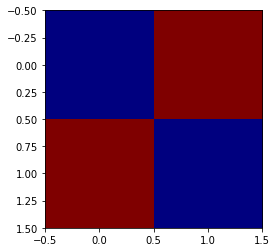

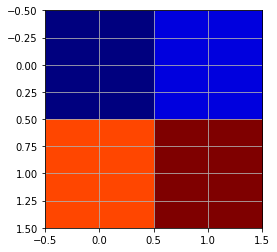

In [54]:
%matplotlib inline
import pylab
A = [[0, 1],[1, 0]]
figure(1)
imshow(A, cmap='jet', interpolation='none')
savefig('foo1.png')

figure(2)
A = [[0.1, 0.11], [0.2, 0.22]]
imshow(A, cmap='jet', interpolation='none')
savefig('foo2.png', frameon=True)
grid(True)

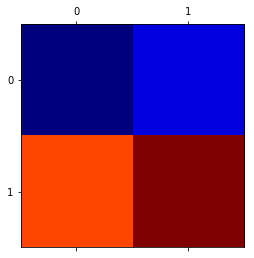

In [59]:

A = [[0.1, 0.11], [0.2, 0.22]]
#imshow(A, interpolation='none')
plt.matshow(A, cmap='jet', interpolation='nearest')
plt.show()

savefig('foo3.png', frameon=True)

In [60]:
from PIL import Image
def SaveImageMaze(CloneMap):
    
    w, h = 512, 512
    data = np.zeros((h, w, 3), dtype=np.uint8)
    data[256, 256] = [255, 0, 0]
    img = Image.fromarray(data, 'RGB')
    img.save('my.png')
    img.show()

In [61]:
vis

NameError: name 'vis' is not defined

In [62]:
ddd = [0,0,0]
for d in ddd:
    d = 1
print ddd

[0, 0, 0]
